In [1]:
import pyodbc
import yfinance as yf
import pandas as pd
from sqlalchemy import create_engine
import datetime
from datetime import date, timedelta

# Verbindungsstring
conn_str = (
    r'Driver=SQL Server;'
    r'Server=.\SQLEXPRESS;'
    r'Database=studienprojekt;'
    r'Trusted_Connection=yes;'
)

# Verbindung zur Datenbank herstellen
cnxn = pyodbc.connect(conn_str)

# SQLAlchemy connectable erstellen
engine = create_engine('mssql+pyodbc://', creator=lambda: cnxn)

# Tabelle prüfen
table_name = "stock_data"  # Name der Zieltabelle
start_date = "2022-07-01"  # Startdatum, ab dem Daten überprüft werden sollen
end_date = "2023-06-01"  # Enddatum, bis zu dem Daten überprüft werden sollen
company_name = "MSFT"  # nur AAPL, MSFT oder GOOG möglich // Name des Unternehmens, für das Daten geladen werden sollen

# Daten aus der Tabelle für das bestimmte Unternehmen in einen DataFrame laden
select_query = f"SELECT * FROM {table_name} WHERE date >= ? AND date <= ? AND Company = ?"
data = pd.read_sql(select_query, con=engine, params=(start_date, end_date, company_name))

# added
data["ID"] = data.index
data = data[["ID", "Date", "Company", "Type", "Open", "High", "Low", "Close", "Volume"]]
data.reset_index(drop=True, inplace=True)

# Verbindung schließen
cnxn.close()

# DataFrame anzeigen
print(data.tail())


      ID       Date Company Type        Open        High         Low  \
226  226 2023-05-25    MSFT  ACT  323.239990  326.899994  320.000000   
227  227 2023-05-26    MSFT  ACT  324.019989  333.399994  323.880005   
228  228 2023-05-30    MSFT  ACT  335.230011  335.739990  330.519989   
229  229 2023-05-31    MSFT  ACT  332.290009  335.940002  327.329987   
230  230 2023-06-01    MSFT  ACT  325.929993  333.529999  324.720001   

          Close    Volume  
226  325.920013  43301700  
227  332.890015  36630600  
228  331.209991  29503100  
229  328.390015  45950600  
230  332.579987  26773900  


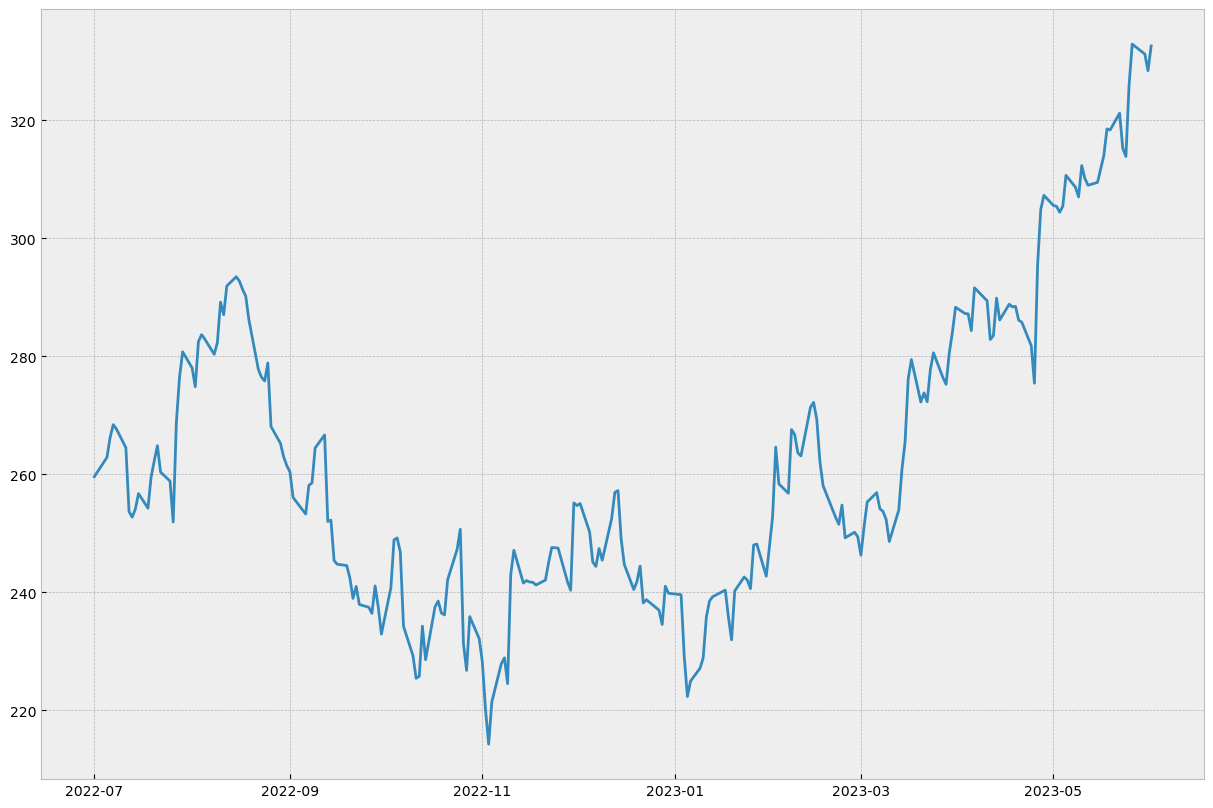

In [2]:
import matplotlib.pyplot as plt
plt.style.use('bmh')
plt.figure(figsize=(15, 10))
plt.plot(data["Date"], data["Close"])

<Figure size 640x480 with 0 Axes>

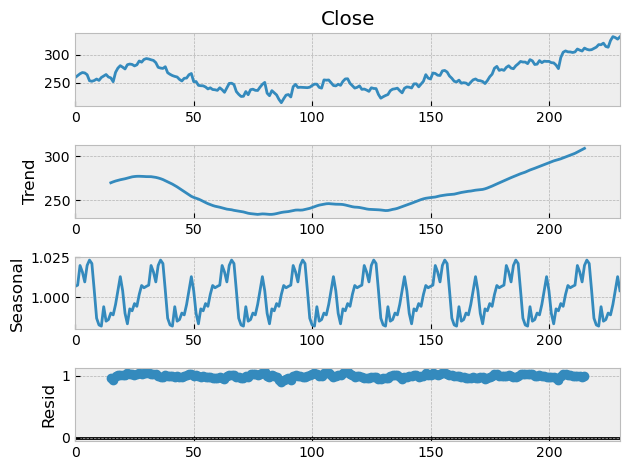

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data["Close"], model='multiplicative', period=30)
fig = plt.figure()  
fig = result.plot() 

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

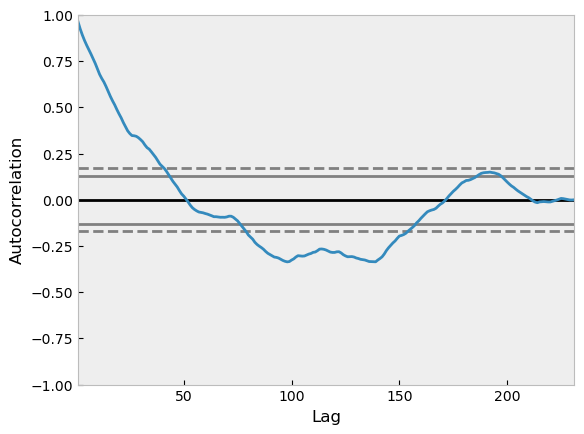

In [4]:
pd.plotting.autocorrelation_plot(data["Close"])

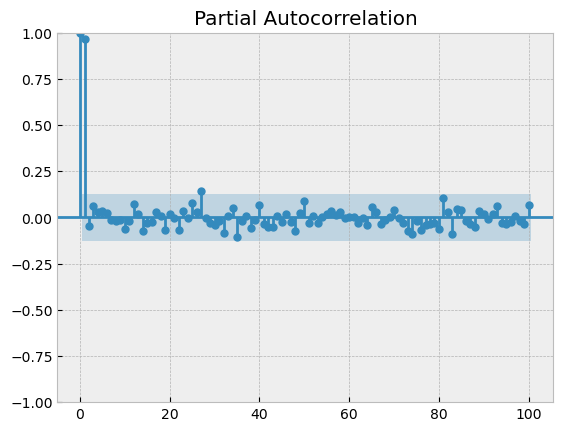

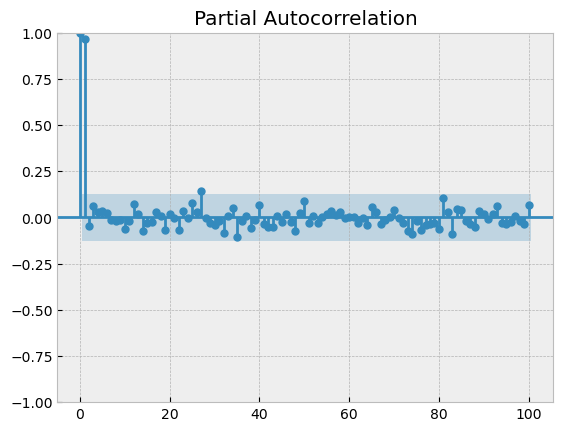

In [5]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data["Close"], lags=100, method='ywm')

In [6]:
p, d, q = 5, 1, 2
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(data["Close"], order=(p,d,q))
fitted = model.fit()

print(fitted.summary())

C:\Users\HerbyHerb\.conda\envs\tf_new\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\HerbyHerb\.conda\envs\tf_new\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  231
Model:                 ARIMA(5, 1, 2)   Log Likelihood                -699.115
Date:                Sat, 08 Jul 2023   AIC                           1414.231
Time:                        21:27:04   BIC                           1441.735
Sample:                             0   HQIC                          1425.326
                                - 231                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1955      0.089      2.190      0.029       0.021       0.370
ar.L2         -1.1300      0.078    -14.489      0.000      -1.283      -0.977
ar.L3          0.0516      0.123      0.421      0.6

C:\Users\HerbyHerb\.conda\envs\tf_new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [7]:
predictions = fitted.predict()
print(predictions)

0        0.000000
1      259.580692
2      263.167995
3      265.969159
4      267.785617
          ...    
226    315.381955
227    328.397310
228    331.225965
229    328.372056
230    328.418681
Name: predicted_mean, Length: 231, dtype: float64


In [8]:
import statsmodels.api as sm
import warnings
import time

# Startzeit messen
start_time = time.time()

model = sm.tsa.statespace.SARIMAX(data['Close'],
                                 order=(p, d, q),
                                 seasonal_order=(p, d, q, 12))
model = model.fit()

# Endzeit messen
end_time = time.time()

# Gesamtdauer berechnen
duration = end_time - start_time

print(model.summary())
print("Durchlaufdauer:", duration, "Sekunden")

C:\Users\HerbyHerb\.conda\envs\tf_new\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\HerbyHerb\.conda\envs\tf_new\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\HerbyHerb\.conda\envs\tf_new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                  231
Model:             SARIMAX(5, 1, 2)x(5, 1, 2, 12)   Log Likelihood                -682.449
Date:                            Sat, 08 Jul 2023   AIC                           1394.899
Time:                                    21:27:20   BIC                           1445.666
Sample:                                         0   HQIC                          1415.405
                                            - 231                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3772      0.952     -0.396      0.692      -2.244       1.489
ar.L2         -0.4121      0.689   

In [9]:
predictions = model.predict(len(data), len(data)+30)
print(predictions)

231    333.886711
232    332.755592
233    331.843167
234    333.410191
235    335.077175
236    334.332515
237    332.990224
238    332.523572
239    335.154278
240    337.276631
241    336.946773
242    336.252465
243    336.376437
244    337.402527
245    335.844723
246    337.777076
247    340.473820
248    341.592216
249    342.706691
250    341.494580
251    341.384028
252    341.982171
253    343.492884
254    344.568703
255    345.230153
256    344.545240
257    344.284855
258    346.201315
259    348.260742
260    349.709341
261    349.346540
Name: predicted_mean, dtype: float64


<Axes: >

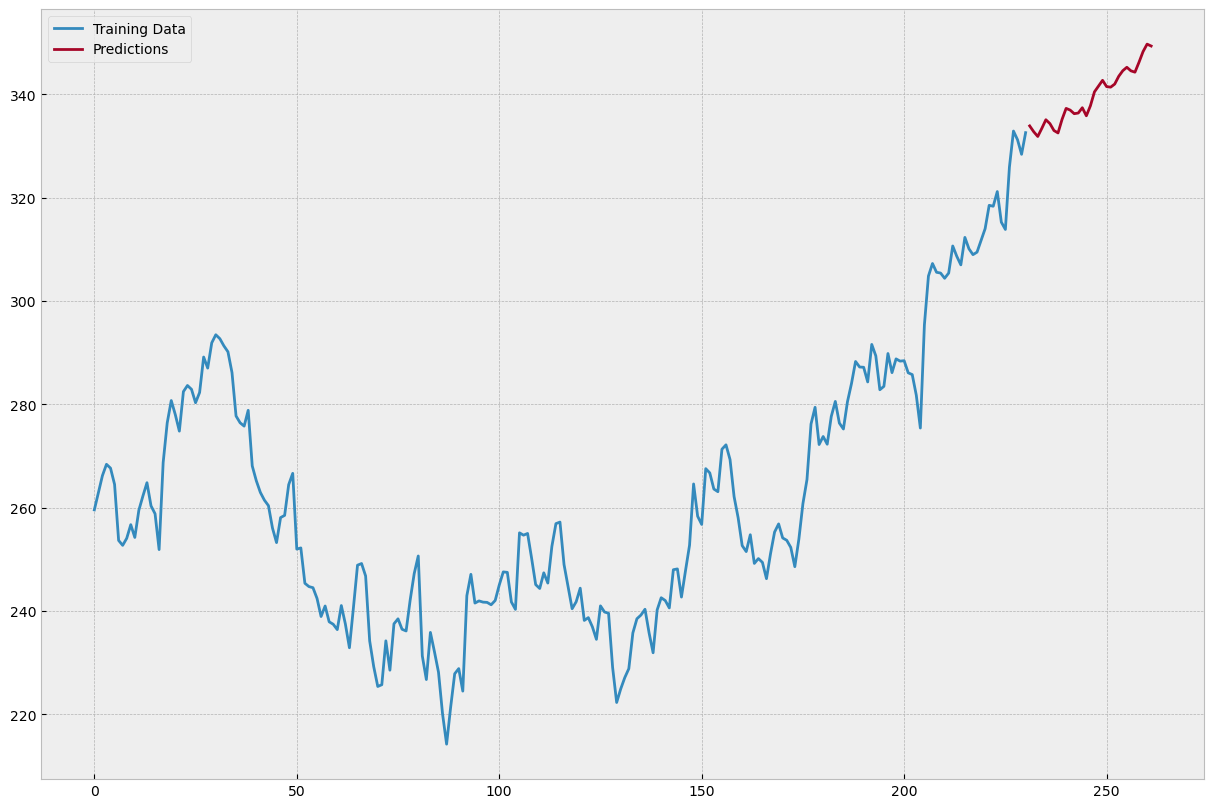

In [10]:
data["Close"].plot(legend=True, label="Training Data", figsize=(15, 10))
predictions.plot(legend=True, label="Predictions")

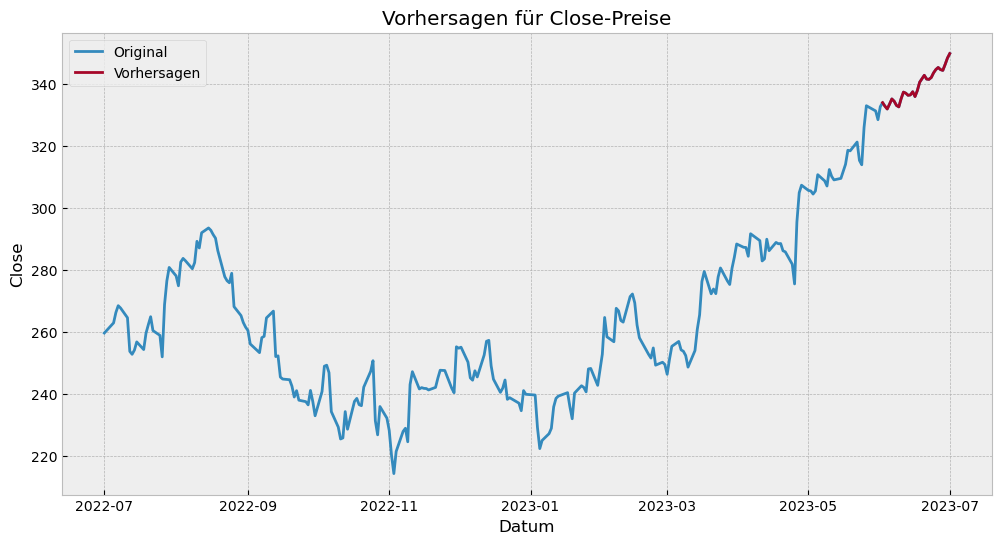

In [11]:
# Vorhersagen für die nächsten 30 Tage erhalten
predictions = model.predict(len(data), len(data) + 29)  # 30 Tage Vorhersagen

# Daten für die nächsten 30 Tage generieren
future_dates = pd.date_range(start=data['Date'].iloc[-1] + timedelta(days=1), periods=30)

# Ein DataFrame für die Vorhersagen erstellen
df_predictions = pd.DataFrame({
    'Date': future_dates,
    'Close': predictions
})

# DataFrame erweitern, indem Sie die Vorhersagen anhängen
data_extended = pd.concat([data, df_predictions])

# Plot erstellen
plt.figure(figsize=(12, 6))
plt.plot(data_extended['Date'], data_extended['Close'], label='Original')
plt.plot(data_extended['Date'].tail(30), data_extended['Close'].tail(30), label='Vorhersagen')
plt.xlabel('Datum')
plt.ylabel('Close')
plt.title('Vorhersagen für Close-Preise')
plt.legend()
plt.grid(True)
plt.show()

In [35]:
data_extended_key = data_extended

In [43]:
# Key einbinden
company = data.loc[0]['Company']
data_extended_key['Company'] = company
data_extended_key['Type'] = data_extended_key['High'].apply(lambda x: f'Arima_{company}' if np.isnan(x) else f'Act_{company}')
data_extended_key.loc[data_extended_key['Type'].str.contains('Arima'), 'Forecast_Date'] = end_date
data_extended_key['Key'] = data_extended_key['Company'] + '_' + data_extended_key['Date'].astype(str) + '_' + data_extended_key['Type']


In [44]:
data_extended_key

,ID,Date,Company,Type,Open,High,Low,Close,Volume,Key,Forecast_Date
0,0.0,2022-07-01,MSFT,Act_MSFT,256.390015,259.769989,254.610001,259.579987,22837700.0,MSFT_2022-07-01_Act_MSFT,NaN
1,1.0,2022-07-05,MSFT,Act_MSFT,256.160004,262.980011,254.740005,262.850006,22941000.0,MSFT_2022-07-05_Act_MSFT,NaN
2,2.0,2022-07-06,MSFT,Act_MSFT,263.750000,267.989990,262.399994,266.209991,23824400.0,MSFT_2022-07-06_Act_MSFT,NaN
3,3.0,2022-07-07,MSFT,Act_MSFT,265.119995,269.059998,265.019989,268.399994,20859900.0,MSFT_2022-07-07_Act_MSFT,NaN
4,4.0,2022-07-08,MSFT,Act_MSFT,264.790009,268.100006,263.290009,267.660004,19658800.0,MSFT_2022-07-08_Act_MSFT,NaN
...,...,...,...,...,...,...,...,...,...,...,...
256,NaN,2023-06-27,MSFT,Arima_MSFT,NaN,NaN,NaN,344.545240,NaN,MSFT_2023-06-27_Arima_MSFT,2023-06-01
257,NaN,2023-06-28,MSFT,Arima_MSFT,NaN,NaN,NaN,344.284855,NaN,MSFT_2023-06-28_Arima_MSFT,2023-06-01
258,NaN,2023-06-29,MSFT,Arima_MSFT,NaN,NaN,NaN,346.201315,NaN,MSFT_2023-06-29_Arima_MSFT,2023-06-01
259,NaN,2023-06-30,MSFT,Arima_MSFT,NaN,NaN,NaN,348.260742,NaN,MSFT_2023-06-30_Arima_MSFT,2023-06-01


In [30]:
import pyodbc
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import warnings

# Deaktivieren der Pandas-Warnungen
warnings.filterwarnings('ignore', category=UserWarning)

# Verbindungsstring
conn_str = (
    r'Driver=SQL Server;'
    r'Server=.\SQLEXPRESS;'
    r'Database=studienprojekt;'
    r'Trusted_Connection=yes;'
)

# Verbindung zur Datenbank herstellen
cnxn = pyodbc.connect(conn_str)

# SQLAlchemy connectable erstellen
engine = create_engine('mssql+pyodbc://', creator=lambda: cnxn)

# Query erstellen, um alle Daten auszulesen
query = "SELECT * FROM stock_data_forecast"

# Ausführen der Query und Laden der Ergebnisse in einen DataFrame
exists_df = pd.read_sql(query, cnxn)

# added
exists_df = exists_df.astype(data_extended.dtypes)
exists_df = exists_df.reindex(columns=data_extended.columns)

# Key einbinden
exists_df['Key'] = exists_df['Company'] + '_' + exists_df['Date'].astype(str) + '_' + exists_df['Type']

In [32]:
exists_df

,ID,Date,Company,Type,Open,High,Low,Close,Volume,Key
0,0.0,2022-07-01,MSFT,Act_MSFT,256.39,259.77,254.61,259.579987,22837700.0,MSFT_2022-07-01_Act_MSFT
1,1.0,2022-07-05,MSFT,Act_MSFT,256.16,262.98,254.74,262.850006,22941000.0,MSFT_2022-07-05_Act_MSFT
2,2.0,2022-07-06,MSFT,Act_MSFT,263.75,267.99,262.40,266.209991,23824400.0,MSFT_2022-07-06_Act_MSFT
3,3.0,2022-07-07,MSFT,Act_MSFT,265.12,269.06,265.02,268.399994,20859900.0,MSFT_2022-07-07_Act_MSFT
4,4.0,2022-07-08,MSFT,Act_MSFT,264.79,268.10,263.29,267.660004,19658800.0,MSFT_2022-07-08_Act_MSFT
...,...,...,...,...,...,...,...,...,...,...
316,NaN,2023-05-27,MSFT,Arima_MSFT,NaN,NaN,NaN,316.167199,NaN,MSFT_2023-05-27_Arima_MSFT
317,NaN,2023-05-28,MSFT,Arima_MSFT,NaN,NaN,NaN,317.332589,NaN,MSFT_2023-05-28_Arima_MSFT
318,NaN,2023-05-29,MSFT,Arima_MSFT,NaN,NaN,NaN,317.672405,NaN,MSFT_2023-05-29_Arima_MSFT
319,NaN,2023-05-30,MSFT,Arima_MSFT,NaN,NaN,NaN,317.004604,NaN,MSFT_2023-05-30_Arima_MSFT


In [45]:
# Zusammenführen der beiden DataFrames
combined_df = pd.concat([exists_df, data_extended_key])



In [46]:
combined_df

,ID,Date,Company,Type,Open,High,Low,Close,Volume,Key,Forecast_Date
0,0.0,2022-07-01,MSFT,Act_MSFT,256.39,259.77,254.61,259.579987,22837700.0,MSFT_2022-07-01_Act_MSFT,NaN
1,1.0,2022-07-05,MSFT,Act_MSFT,256.16,262.98,254.74,262.850006,22941000.0,MSFT_2022-07-05_Act_MSFT,NaN
2,2.0,2022-07-06,MSFT,Act_MSFT,263.75,267.99,262.40,266.209991,23824400.0,MSFT_2022-07-06_Act_MSFT,NaN
3,3.0,2022-07-07,MSFT,Act_MSFT,265.12,269.06,265.02,268.399994,20859900.0,MSFT_2022-07-07_Act_MSFT,NaN
4,4.0,2022-07-08,MSFT,Act_MSFT,264.79,268.10,263.29,267.660004,19658800.0,MSFT_2022-07-08_Act_MSFT,NaN
...,...,...,...,...,...,...,...,...,...,...,...
256,NaN,2023-06-27,MSFT,Arima_MSFT,NaN,NaN,NaN,344.545240,NaN,MSFT_2023-06-27_Arima_MSFT,2023-06-01
257,NaN,2023-06-28,MSFT,Arima_MSFT,NaN,NaN,NaN,344.284855,NaN,MSFT_2023-06-28_Arima_MSFT,2023-06-01
258,NaN,2023-06-29,MSFT,Arima_MSFT,NaN,NaN,NaN,346.201315,NaN,MSFT_2023-06-29_Arima_MSFT,2023-06-01
259,NaN,2023-06-30,MSFT,Arima_MSFT,NaN,NaN,NaN,348.260742,NaN,MSFT_2023-06-30_Arima_MSFT,2023-06-01


In [47]:
# Entfernen von Duplikaten
combined_df = combined_df.drop_duplicates(subset=['Key'], keep=False)

In [48]:
combined_df

,ID,Date,Company,Type,Open,High,Low,Close,Volume,Key,Forecast_Date


In [24]:
# Key einbinden
combined_df['Key'] = data_extended['Company'] + '_' + data_extended['Date'].astype(str) + '_' + data_extended['Type']

In [25]:
combined_df

,ID,Date,Company,Type,Open,High,Low,Close,Volume,Key
0,0.0,2022-07-01,MSFT,Act_MSFT,256.39,259.77,254.61,259.579987,22837700.0,MSFT_2022-07-01_ACT
1,1.0,2022-07-05,MSFT,Act_MSFT,256.16,262.98,254.74,262.850006,22941000.0,MSFT_2022-07-05_ACT
2,2.0,2022-07-06,MSFT,Act_MSFT,263.75,267.99,262.40,266.209991,23824400.0,MSFT_2022-07-06_ACT
3,3.0,2022-07-07,MSFT,Act_MSFT,265.12,269.06,265.02,268.399994,20859900.0,MSFT_2022-07-07_ACT
4,4.0,2022-07-08,MSFT,Act_MSFT,264.79,268.10,263.29,267.660004,19658800.0,MSFT_2022-07-08_ACT
...,...,...,...,...,...,...,...,...,...,...
256,NaN,2023-06-27,NaN,NaN,NaN,NaN,NaN,344.545240,NaN,NaN
257,NaN,2023-06-28,NaN,NaN,NaN,NaN,NaN,344.284855,NaN,NaN
258,NaN,2023-06-29,NaN,NaN,NaN,NaN,NaN,346.201315,NaN,NaN
259,NaN,2023-06-30,NaN,NaN,NaN,NaN,NaN,348.260742,NaN,NaN
